In [2]:
import pybinding as pb
from pybinding.repository import graphene
from pybinding.repository import phosphorene
from pybinding.repository import group6_tmd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageCms
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import scipy.stats as stats
import cv2
import traceback
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
from pathlib import Path
from skimage import measure, feature, filters, exposure
from pathlib import Path
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import joblib

C:\Users\batenehsan\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Main code for create random images with features

In [ ]:
# -------------------- CONFIGURATION SECTION --------------------
# Set your desired system size in nanometers here
SYSTEM_SIZE_NM = (2,2)  # Change this to your desired size (width, height), this size must set so similar to the experimental images

# Select which material to use
MATERIAL_NAME = "graphene"  # Options: "graphene", "phosphorene", "MoS2"

# Other configuration parameters
NUM_IMAGES = 500          # number of images that you want to create as the training the model, this so depend on the image size of experimentsl 
SCALE_FACTOR = 0.01  # Adjust this to control the relationship between image pixels and system size
# ---------------------------------------------------------------

In [3]:
# Import different material models
try:
    from pybinding.repository import graphene, phosphorene
    
    # Define material functions dictionary
    material_functions = {
        "graphene": graphene.monolayer,
        "phosphorene": phosphorene.monolayer_4band,
        "MoS2": group6_tmd.monolayer_3band
    }
    
    material_func = material_functions[MATERIAL_NAME]
    
except ImportError as e:
    print(f"Warning: Could not import some materials: {e}")
    # Fallback to MoS2 if other materials are not available
    material_func = group6_tmd.monolayer_3band
    MATERIAL_NAME = "MoS2"

# Calculate scaled parameters based on system size
BASE_SIZE = 5.0  # Original base size
size_ratio = SYSTEM_SIZE_NM[0] / BASE_SIZE

# Scale all size-dependent parameters
RADIUS_RANGE = (0.12 * size_ratio, 0.7 * size_ratio)
MARGIN = 0.3 * size_ratio
SITE_RADIUS = 0.04 * size_ratio
DPI = int(300 * size_ratio)

print(f"Configuration:")
print(f"  System size: {SYSTEM_SIZE_NM[0]} x {SYSTEM_SIZE_NM[1]} nm")
print(f"  Material: {MATERIAL_NAME}")
print(f"  Scaled parameters:")
print(f"    Radius range: {RADIUS_RANGE}")
print(f"    Margin: {MARGIN}")
print(f"    Site radius: {SITE_RADIUS}")
print(f"    DPI: {DPI}")

# -------------------- Part 1: Image Generation with Defects --------------------

def create_vacancy_modifier(position: Tuple[float, float], radius: float):
    """
    Create a site state modifier that creates a circular vacancy defect.
    """
    @pb.site_state_modifier
    def modifier(state, x, y):
        x0, y0 = position
        state[(x - x0)**2 + (y - y0)**2 < radius**2] = False
        return state
    return modifier

def generate_defect_images(
    material_func, 
    material_name: str, 
    num_images: int = NUM_IMAGES, 
    system_size: Tuple[float, float] = SYSTEM_SIZE_NM,
    radius_range: Tuple[float, float] = RADIUS_RANGE,
    output_dir: str = "defect_images",
    margin: float = MARGIN
) -> pd.DataFrame:
    """
    Generate multiple images of material systems with vacancy defects.
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    targets, x_positions, y_positions, radii = [], [], [], []
    x_half, y_half = system_size[0] / 2, system_size[1] / 2
    
    plt.rcParams.update({'figure.max_open_warning': 0})
    
    for image_num in range(1, num_images + 1):
        max_radius = min(x_half, y_half) - margin
        defect_radius = np.random.uniform(radius_range[0], min(radius_range[1], max_radius))
        
        x_min = -x_half + defect_radius + margin
        x_max = x_half - defect_radius - margin
        y_min = -y_half + defect_radius + margin
        y_max = y_half - defect_radius - margin
        
        if x_min >= x_max or y_min >= y_max:
            print(f"Warning: Cannot place defect with radius {defect_radius} in system of size {system_size}")
            continue
            
        defect_x = np.random.uniform(x_min, x_max)
        defect_y = np.random.uniform(y_min, y_max)
        
        # Handle different material function signatures
        if material_name in ["MoS2", "WS2", "MoSe2", "WSe2"]:
            # For TMD materials, pass the material name
            lattice = material_func(material_name)
        else:
            # For graphene and phosphorene, call without arguments
            lattice = material_func()
        
        model = pb.Model(
            lattice,
            pb.rectangle(*system_size),
            create_vacancy_modifier(position=[defect_x, defect_y], radius=defect_radius)
        )
        
        system_area = system_size[0] * system_size[1]
        vacancy_area_percentage = (np.pi * defect_radius**2) / system_area * 100
        targets.append(vacancy_area_percentage)
        
        x_positions.append(defect_x + x_half)
        y_positions.append(defect_y + y_half)
        radii.append(defect_radius)
        
        plt.figure(dpi=DPI, facecolor='none')
        model.plot(site={'radius': SITE_RADIUS, 'cmap': ['black', 'black']})
        plt.box(False)
        plt.axis('off')
        
        filename = output_path / f"pic_{material_name}_{image_num:03d}.jpg"
        plt.savefig(filename, bbox_inches='tight', transparent=True)
        plt.close()
    
    df_main = pd.DataFrame({
        'X': x_positions,
        'Y': y_positions,
        'R': radii,
        'target': targets
    })
    
    csv_path = output_path / "defect_data.csv"
    df_main.to_csv(csv_path, index=False)
    print(f"Defect data saved to: {csv_path}")
    
    return df_main

# -------------------- Part 2: Image Processing --------------------

def process_images_to_grayscale(input_folder: str, output_folder: str) -> None:
    """
    Process images by converting to grayscale, applying thresholding, 
    morphological operations, and cropping before saving.
    """
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)
    
    input_path = Path(input_folder)
    if not input_path.exists():
        print(f"Error: Input directory '{input_folder}' does not exist.")
        return
    
    image_files = list(input_path.glob("*.*"))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']]
    
    if not image_files:
        print(f"No image files found in '{input_folder}'.")
        return
    
    print(f"Found {len(image_files)} image files to process.")
    
    processed_count = 0
    for image_no, image_path in enumerate(image_files, 1):
        try:
            print(f"Processing image {image_no}/{len(image_files)}: {image_path.name}")
            
            with Image.open(image_path) as img:
                img_gray = img.convert('L')
                img_rgb = img_gray.convert('RGB')
                img_cv = cv2.cvtColor(np.array(img_rgb), cv2.COLOR_RGB2BGR)
                gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
                
                _, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
                
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
                morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
                
                contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    largest_contour = max(contours, key=cv2.contourArea)
                    
                    x, y, w, h = cv2.boundingRect(largest_contour)
                    dst = img_cv[y:y+h, x:x+w]
                    
                    dst = cv2.copyMakeBorder(dst, 3, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255, 255])
                    
                    floodfill_color = (123, 123, 123)
                    seed_point = (0, 0)
                    
                    h, w = dst.shape[:2]
                    mask = np.zeros((h+2, w+2), np.uint8)
                    
                    cv2.floodFill(dst, mask, seed_point, floodfill_color)
                    
                    output_filename = output_path / f"picture_{image_no}.jpg"
                    cv2.imwrite(str(output_filename), dst)
                    
                    print(f"Successfully processed and saved: {output_filename.name}")
                    processed_count += 1
                else:
                    print(f"No contours found in image: {image_path.name}")
                    
        except Exception as e:
            print(f"Error processing image {image_path.name}: {str(e)}")
            continue
    
    print(f"Processing complete. Successfully processed {processed_count} out of {len(image_files)} images.")

# -------------------- Part 3: Feature Extraction --------------------

def extract_enhanced_image_features(image_path: Path) -> Dict[str, float]:
    """
    Extract enhanced features from an image containing a hole.
    """
    try:
        img = Image.open(image_path).convert('L')
        WIDTH, HEIGHT = img.size
        
        img_array = np.array(img)
        
        sum_y = np.sum(img_array, axis=1)
        sum_x = np.sum(img_array, axis=0)
        
        max_y = np.max(sum_y)
        max_x = np.max(sum_x)
        
        max_y_positions = np.where(sum_y == max_y)[0]
        max_x_positions = np.where(sum_x == max_x)[0]
        
        sum_y_stats = {
            'mean': np.mean(sum_y),
            'std': np.std(sum_y),
            'skew': stats.skew(sum_y),
            'kurtosis': stats.kurtosis(sum_y),
            'median': np.median(sum_y),
            'q1': np.percentile(sum_y, 25),
            'q3': np.percentile(sum_y, 75),
            'iqr': np.percentile(sum_y, 75) - np.percentile(sum_y, 25)
        }
        
        sum_x_stats = {
            'mean': np.mean(sum_x),
            'std': np.std(sum_x),
            'skew': stats.skew(sum_x),
            'kurtosis': stats.kurtosis(sum_x),
            'median': np.median(sum_x),
            'q1': np.percentile(sum_x, 25),
            'q3': np.percentile(sum_x, 75),
            'iqr': np.percentile(sum_x, 75) - np.percentile(sum_x, 25)
        }
        
        img_stats = {
            'mean_intensity': np.mean(img_array),
            'std_intensity': np.std(img_array),
            'min_intensity': np.min(img_array),
            'max_intensity': np.max(img_array),
            'entropy': stats.entropy(img_array.flatten()),
        }
        
        grad_x = filters.sobel_h(img_array)
        grad_y = filters.sobel_v(img_array)
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        
        gradient_stats = {
            'mean_gradient': np.mean(grad_magnitude),
            'std_gradient': np.std(grad_magnitude),
            'max_gradient': np.max(grad_magnitude),
        }
        
        threshold = np.mean(img_array) - np.std(img_array)
        binary_img = img_array < threshold
        
        labeled_img = measure.label(binary_img)
        regions = measure.regionprops(labeled_img, intensity_image=img_array)
        
        if regions:
            largest_region = max(regions, key=lambda x: x.area)
            hole_props = {
                'hole_area': largest_region.area,
                'hole_perimeter': largest_region.perimeter,
                'hole_eccentricity': largest_region.eccentricity,
                'hole_solidity': largest_region.solidity,
                'hole_centroid_y': largest_region.centroid[0],
                'hole_centroid_x': largest_region.centroid[1],
                'hole_major_axis': largest_region.major_axis_length,
                'hole_minor_axis': largest_region.minor_axis_length,
                'hole_mean_intensity': largest_region.mean_intensity,
            }
        else:
            hole_props = {
                'hole_area': 0,
                'hole_perimeter': 0,
                'hole_eccentricity': 0,
                'hole_solidity': 0,
                'hole_centroid_y': 0,
                'hole_centroid_x': 0,
                'hole_major_axis': 0,
                'hole_minor_axis': 0,
                'hole_mean_intensity': 0,
            }
        
        features = {
            'image_path': str(image_path),
            'width': WIDTH,
            'height': HEIGHT,
            'max_sum_y': max_y,
            'max_sum_x': max_x,
            'max_y_pos_count': len(max_y_positions),
            'max_x_pos_count': len(max_x_positions),
            'max_y_pos_mean': np.mean(max_y_positions) if len(max_y_positions) > 0 else 0,
            'max_x_pos_mean': np.mean(max_x_positions) if len(max_x_positions) > 0 else 0,
            'max_y_pos_std': np.std(max_y_positions) if len(max_y_positions) > 0 else 0,
            'max_x_pos_std': np.std(max_x_positions) if len(max_x_positions) > 0 else 0,
        }
        
        for key, value in sum_y_stats.items():
            features[f'sum_y_{key}'] = value  # Fixed: Added closing brace
            
        for key, value in sum_x_stats.items():
            features[f'sum_x_{key}'] = value  # Fixed: Added closing brace
            
        for key, value in img_stats.items():
            features[key] = value
            
        for key, value in gradient_stats.items():
            features[key] = value
            
        for key, value in hole_props.items():
            features[key] = value
        
        return features
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        print(traceback.format_exc())
        return None

def remove_constant_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove columns from DataFrame where all values are the same (constant),
    but preserve certain metadata columns.
    """
    # List of columns to keep even if constant
    metadata_columns = ['width', 'height', 'image_path']
    
    constant_columns = []
    for column in df.columns:
        if column not in metadata_columns and df[column].nunique() <= 1:
            constant_columns.append(column)
    
    if constant_columns:
        print(f"Removing constant columns: {constant_columns}")
        df = df.drop(columns=constant_columns)
    else:
        print("No constant columns found.")
    
    return df

def create_comprehensive_dataframe(image_folder: str, defect_data_path: str) -> pd.DataFrame:
    """
    Create a comprehensive DataFrame with defect parameters and enhanced image features.
    """
    defect_csv_path = Path(defect_data_path) / "defect_data.csv"
    if defect_csv_path.exists():
        try:
            df_defect = pd.read_csv(defect_csv_path)
            print(f"Loaded defect data from {defect_csv_path}")
        except Exception as e:
            print(f"Error loading defect data: {e}")
            df_defect = pd.DataFrame(columns=['X', 'Y', 'R', 'target'])
    else:
        print(f"Defect data file not found at {defect_csv_path}")
        df_defect = pd.DataFrame(columns=['X', 'Y', 'R', 'target'])
    
    folder_path = Path(image_folder)
    image_files = list(folder_path.glob("*.*"))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']]
    
    if not image_files:
        print(f"No image files found in '{image_folder}'.")
        return pd.DataFrame()
    
    print(f"Found {len(image_files)} image files to process.")
    
    def get_image_number(image_path):
        try:
            return int(image_path.stem.split('_')[-1])
        except:
            return None
    
    features_list = []
    for i, image_path in enumerate(image_files, 1):
        print(f"Processing image {i}/{len(image_files)}: {image_path.name}")
        
        image_no = get_image_number(image_path)
        if image_no is None:
            print(f"Could not extract image number from {image_path.name}")
            continue
        
        features = extract_enhanced_image_features(image_path)
        if features:
            if not df_defect.empty and image_no <= len(df_defect):
                try:
                    features['X'] = df_defect.loc[image_no-1, 'X']
                    features['Y'] = df_defect.loc[image_no-1, 'Y']
                    features['R'] = df_defect.loc[image_no-1, 'R']
                    features['target'] = df_defect.loc[image_no-1, 'target']
                except KeyError as e:
                    print(f"Missing column in defect data: {e}")
                    features['X'] = features['Y'] = features['R'] = features['target'] = np.nan
            else:
                features['X'] = features['Y'] = features['R'] = features['target'] = np.nan
            
            features_list.append(features)
    
    if features_list:
        df_features = pd.DataFrame(features_list)
        
        defect_cols = ['X', 'Y', 'R', 'target']
        other_cols = [col for col in df_features.columns if col not in defect_cols]
        ordered_cols = defect_cols + other_cols
        
        df_features = df_features[ordered_cols]
        
        df_features = remove_constant_columns(df_features)
        
        print(f"Successfully extracted features from {len(features_list)} images.")
        return df_features
    else:
        print("No features were extracted from any images.")
        return pd.DataFrame()

# -------------------- Main Execution --------------------

if __name__ == "__main__":
    np.random.seed(42)
    
    # Set paths
    raw_images_dir = r"\defpic"   # path of random images created
    processed_images_dir = r"\defpicture"  # path of processed images with grayscale and border
    
    print("Step 1: Generating images with defects...")
    df_main = generate_defect_images(
        material_func=material_func,
        material_name=MATERIAL_NAME,
        num_images=NUM_IMAGES,
        system_size=SYSTEM_SIZE_NM,
        radius_range=RADIUS_RANGE,
        margin=MARGIN,
        output_dir=raw_images_dir
    )
    
    print("\nStep 2: Processing images...")
    process_images_to_grayscale(raw_images_dir, processed_images_dir)
    
    print("\nStep 3: Extracting features and creating comprehensive DataFrame...")
    df_comprehensive = create_comprehensive_dataframe(processed_images_dir, raw_images_dir)
    
    if not df_comprehensive.empty:
        print("\nComprehensive DataFrame with Defect Parameters and Image Features:")
        print(df_comprehensive.head(2))
        
        print("\nColumn Information:")
        for col in df_comprehensive.columns:
            print(f"- {col}")
        
        csv_path = Path(processed_images_dir) / "comprehensive_features.csv"
        df_comprehensive.to_csv(csv_path, index=False)
        print(f"\nComprehensive features saved to: {csv_path}")
        
        print(f"\nDataFrame shape: {df_comprehensive.shape}")
        print(f"Number of features: {len(df_comprehensive.columns)}")
        
        print(f"\nGenerated image dimensions: {df_comprehensive['width'].iloc[0]} x {df_comprehensive['height'].iloc[0]}")
    else:
        print("No features were extracted. Check the error messages above.")

Configuration:
  System size: 2 x 2 nm
  Material: graphene
  Scaled parameters:
    Radius range: (0.048, 0.27999999999999997)
    Margin: 0.12
    Site radius: 0.016
    DPI: 120
Step 1: Generating images with defects...
Defect data saved to: L:\py.pro\Defect\defpic\defect_data.csv

Step 2: Processing images...
Found 500 image files to process.
Processing image 1/500: pic_graphene_001.jpg
Successfully processed and saved: picture_1.jpg
Processing image 2/500: pic_graphene_002.jpg
Successfully processed and saved: picture_2.jpg
Processing image 3/500: pic_graphene_003.jpg
Successfully processed and saved: picture_3.jpg
Processing image 4/500: pic_graphene_004.jpg
Successfully processed and saved: picture_4.jpg
Processing image 5/500: pic_graphene_005.jpg
Successfully processed and saved: picture_5.jpg
Processing image 6/500: pic_graphene_006.jpg
Successfully processed and saved: picture_6.jpg
Processing image 7/500: pic_graphene_007.jpg
Successfully processed and saved: picture_7.jpg


# Load Experimental image

In [4]:
def preprocess_experimental_image(image_path: str, output_path: str = None) -> str:
    """
    Preprocess an experimental STM image to make it suitable for feature extraction.
    Inverts the image to match the format of simulated images (defects as white, background as black).
    """
    try:
        # Open the image
        img = Image.open(image_path)
        print(f"Original image mode: {img.mode}, size: {img.size}")
        
        # Convert to grayscale if needed
        if img.mode != 'L':
            img = img.convert('L')
            print("Converted image to grayscale")
        
        # Invert the image so defects become white and background black
        # This matches the format of our simulated images
        img = ImageOps.invert(img)
        
        # Apply histogram equalization to enhance contrast
        img_array = np.array(img)
        img_array = exposure.equalize_hist(img_array)
        img_array = (img_array * 255).astype(np.uint8)
        
        # Convert back to PIL Image
        img = Image.fromarray(img_array)
        
        # Apply additional contrast enhancement
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)  # Moderate contrast enhancement
        
        # Apply noise reduction
        img = img.filter(ImageFilter.MedianFilter(size=3))
        
        # Save the processed image if output path is provided
        if output_path:
            img.save(output_path)
            print(f"Processed image saved to: {output_path}")
        
        return output_path if output_path else image_path
        
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        traceback.print_exc()
        return image_path

def extract_features_from_experimental_image(image_path: Path) -> Dict[str, float]:
    """
    Extract features from an experimental STM image.
    Uses the exact same feature extraction as the main code.
    """
    try:
        # Open and ensure image is in grayscale
        img = Image.open(image_path).convert('L')
        WIDTH, HEIGHT = img.size
        
        # Convert image data to a numpy array
        img_array = np.array(img)
        
        # Calculate sums along axes
        sum_y = np.sum(img_array, axis=1)  # Sum along rows (y-axis)
        sum_x = np.sum(img_array, axis=0)  # Sum along columns (x-axis)
        
        # Find maximum values and their positions
        max_y = np.max(sum_y)
        max_x = np.max(sum_x)
        
        # Find positions of maximum values
        max_y_positions = np.where(sum_y == max_y)[0]
        max_x_positions = np.where(sum_x == max_x)[0]
        
        # Calculate statistics for the distribution of sums
        sum_y_stats = {
            'mean': np.mean(sum_y),
            'std': np.std(sum_y),
            'skew': stats.skew(sum_y) if len(sum_y) > 1 else 0,
            'kurtosis': stats.kurtosis(sum_y) if len(sum_y) > 1 else 0,
            'median': np.median(sum_y),
            'q1': np.percentile(sum_y, 25) if len(sum_y) > 0 else 0,
            'q3': np.percentile(sum_y, 75) if len(sum_y) > 0 else 0,
            'iqr': (np.percentile(sum_y, 75) - np.percentile(sum_y, 25)) if len(sum_y) > 0 else 0
        }
        
        sum_x_stats = {
            'mean': np.mean(sum_x),
            'std': np.std(sum_x),
            'skew': stats.skew(sum_x) if len(sum_x) > 1 else 0,
            'kurtosis': stats.kurtosis(sum_x) if len(sum_x) > 1 else 0,
            'median': np.median(sum_x),
            'q1': np.percentile(sum_x, 25) if len(sum_x) > 0 else 0,
            'q3': np.percentile(sum_x, 75) if len(sum_x) > 0 else 0,
            'iqr': (np.percentile(sum_x, 75) - np.percentile(sum_x, 25)) if len(sum_x) > 0 else 0
        }
        
        # Calculate image-wide statistics
        img_stats = {
            'mean_intensity': np.mean(img_array),
            'std_intensity': np.std(img_array),
            'min_intensity': np.min(img_array),
            'max_intensity': np.max(img_array),
            'entropy': stats.entropy(img_array.flatten()) if np.any(img_array) else 0,
        }
        
        # Calculate gradient features using Sobel filters
        grad_x = filters.sobel_h(img_array)
        grad_y = filters.sobel_v(img_array)
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        
        gradient_stats = {
            'mean_gradient': np.mean(grad_magnitude),
            'std_gradient': np.std(grad_magnitude),
            'max_gradient': np.max(grad_magnitude),
        }
        
        # Calculate hole properties using thresholding
        # Use the same approach as in the main code
        threshold = np.mean(img_array) - np.std(img_array)
        binary_img = img_array < threshold
        
        # Find connected components (the hole)
        labeled_img = measure.label(binary_img)
        regions = measure.regionprops(labeled_img, intensity_image=img_array)
        
        # If we found regions, get the largest one (assumed to be the hole)
        if regions:
            largest_region = max(regions, key=lambda x: x.area)
            hole_props = {
                'hole_area': largest_region.area,
                'hole_perimeter': largest_region.perimeter,
                'hole_eccentricity': largest_region.eccentricity,
                'hole_solidity': largest_region.solidity,
                'hole_centroid_y': largest_region.centroid[0],
                'hole_centroid_x': largest_region.centroid[1],
                'hole_major_axis': largest_region.major_axis_length,
                'hole_minor_axis': largest_region.minor_axis_length,
                'hole_mean_intensity': largest_region.mean_intensity,
            }
        else:
            hole_props = {
                'hole_area': 0,
                'hole_perimeter': 0,
                'hole_eccentricity': 0,
                'hole_solidity': 0,
                'hole_centroid_y': 0,
                'hole_centroid_x': 0,
                'hole_major_axis': 0,
                'hole_minor_axis': 0,
                'hole_mean_intensity': 0,
            }
        
        # Combine all features
        features = {
            'image_path': str(image_path),
            'width': WIDTH,
            'height': HEIGHT,
            'max_sum_y': max_y,
            'max_sum_x': max_x,
            'max_y_pos_count': len(max_y_positions),
            'max_x_pos_count': len(max_x_positions),
            'max_y_pos_mean': np.mean(max_y_positions) if len(max_y_positions) > 0 else 0,
            'max_x_pos_mean': np.mean(max_x_positions) if len(max_x_positions) > 0 else 0,
            'max_y_pos_std': np.std(max_y_positions) if len(max_y_positions) > 0 else 0,
            'max_x_pos_std': np.std(max_x_positions) if len(max_x_positions) > 0 else 0,
        }
        
        # Add sum distribution statistics
        for key, value in sum_y_stats.items():
            features[f'sum_y_{key}'] = value
            
        for key, value in sum_x_stats.items():
            features[f'sum_x_{key}'] = value
            
        # Add image statistics
        for key, value in img_stats.items():
            features[key] = value
            
        # Add gradient statistics
        for key, value in gradient_stats.items():
            features[key] = value
            
        # Add hole properties
        for key, value in hole_props.items():
            features[key] = value
        
        print(f"Successfully extracted {len(features)} features from experimental image")
        return features
        
    except Exception as e:
        print(f"Error processing experimental image {image_path}: {str(e)}")
        traceback.print_exc()
        return None

def process_experimental_image(experimental_image_path: str, output_dir: str = None) -> pd.DataFrame:
    """
    Process an experimental STM image and extract features.
    Uses the exact same feature extraction as the main code.
    """
    # Create output directory if specified
    if output_dir:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        processed_image_path = output_path / "processed_experimental_image.jpg"
    else:
        processed_image_path = None
    
    # Preprocess the experimental image
    print("Preprocessing experimental image...")
    processed_path = preprocess_experimental_image(experimental_image_path, processed_image_path)
    
    # Extract features from the processed image
    print("Extracting features from experimental image...")
    features = extract_features_from_experimental_image(Path(processed_path))
    
    if features:
        # Create DataFrame
        df = pd.DataFrame([features])
        
        # Since it's an experimental image, we don't have X, Y, R, target values
        # Add them as NaN
        df['X'] = np.nan
        df['Y'] = np.nan
        df['R'] = np.nan
        df['target'] = np.nan
        
        # Reorder columns to put defect parameters first
        defect_cols = ['X', 'Y', 'R', 'target']
        other_cols = [col for col in df.columns if col not in defect_cols]
        ordered_cols = defect_cols + other_cols
        
        df = df[ordered_cols]
        
        print("Successfully processed experimental image and extracted features")
        return df
    else:
        print("Failed to extract features from experimental image")
        return pd.DataFrame()

# Main execution
if __name__ == "__main__":
    # Set paths
    experimental_image_path = r"\7_def.jpg"   # path of experimental images so as STM  
    output_dir = r"\experimental_results"   # path of saved resluts
    
    # Process the experimental image
    df_experimental = process_experimental_image(experimental_image_path, output_dir)
    
    if not df_experimental.empty:
        # Display the results
        print("\nExperimental Image Features:")
        print(df_experimental.head())
        
        # Save the results to CSV
        csv_path = Path(output_dir) / "experimental_features.csv"
        df_experimental.to_csv(csv_path, index=False)
        print(f"\nExperimental features saved to: {csv_path}")
        
        # Display information about the DataFrame
        print(f"\nDataFrame shape: {df_experimental.shape}")
        print(f"Number of features: {len(df_experimental.columns)}")
        
        # Display the feature values
        print("\nFeature Values:")
        for col in df_experimental.columns:
            print(f"{col}: {df_experimental[col].values[0]}")
    else:
        print("Failed to process experimental image.")

Preprocessing experimental image...
Original image mode: RGB, size: (143, 146)
Converted image to grayscale
Processed image saved to: L:\py.pro\Defect\experimental_results\processed_experimental_image.jpg
Extracting features from experimental image...
Successfully extracted 44 features from experimental image
Successfully processed experimental image and extracted features

Experimental Image Features:
    X   Y   R  target                                         image_path  \
0 NaN NaN NaN     NaN  L:\py.pro\Defect\experimental_results\processe...   

   width  height  max_sum_y  max_sum_x  max_y_pos_count  ...  max_gradient  \
0    143     146      36465      37183                2  ...      0.640287   

   hole_area  hole_perimeter  hole_eccentricity  hole_solidity  \
0     1576.0      835.914826            0.93697       0.276637   

   hole_centroid_y  hole_centroid_x  hole_major_axis  hole_minor_axis  \
0        74.906091        57.269036       155.659891         54.38898   

   h

# predicion with ML

In [5]:
def load_and_prepare_data(simulated_data_path, experimental_data_path):
    """
    Load and prepare data for model training and prediction.
    """
    # Load simulated data for training
    df_simulated = pd.read_csv(simulated_data_path)
    
    # Load experimental data for prediction
    df_experimental = pd.read_csv(experimental_data_path)
    
    # Separate features and targets
    # Remove non-feature columns
    non_feature_cols = ['X', 'Y', 'R', 'target', 'image_path']
    feature_cols = [col for col in df_simulated.columns if col not in non_feature_cols]
    
    X_train = df_simulated[feature_cols]
    y_train_x = df_simulated['X']
    y_train_y = df_simulated['Y']
    y_train_r = df_simulated['R']
    y_train_target = df_simulated['target']
    
    X_test = df_experimental[feature_cols]
    
    return X_train, y_train_x, y_train_y, y_train_r, y_train_target, X_test, feature_cols

def select_and_rank_features(X_train, y_train, feature_names, n_features=10):
    """
    Select and rank features based on Random Forest feature importance.
    Returns the selected feature indices and their importance scores.
    """
    # Train a Random Forest to get feature importance
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    
    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Select top n features
    selected_indices = indices[:n_features]
    
    # Create a DataFrame with feature names and importance scores
    feature_importance_df = pd.DataFrame({
        'feature': [feature_names[i] for i in selected_indices],
        'importance': importances[selected_indices]
    }).sort_values('importance', ascending=False)
    
    return selected_indices, feature_importance_df

def train_models_with_cv(X_train, y_train_x, y_train_y, y_train_r, y_train_target, feature_names, n_folds=5):
    """
    Train Random Forest models for each target variable with 5-fold cross-validation.
    """
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Select and rank top features for each target
    top_features_x, importance_x = select_and_rank_features(X_train_scaled, y_train_x, feature_names)
    top_features_y, importance_y = select_and_rank_features(X_train_scaled, y_train_y, feature_names)
    top_features_r, importance_r = select_and_rank_features(X_train_scaled, y_train_r, feature_names)
    top_features_target, importance_target = select_and_rank_features(X_train_scaled, y_train_target, feature_names)
    
    # Initialize models
    model_x = RandomForestRegressor(random_state=42)
    model_y = RandomForestRegressor(random_state=42)
    model_r = RandomForestRegressor(random_state=42)
    model_target = RandomForestRegressor(random_state=42)
    
    # Perform 5-fold cross-validation for each model
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_scores_x = cross_val_score(model_x, X_train_scaled[:, top_features_x], y_train_x, 
                                 cv=cv, scoring='r2')
    cv_scores_y = cross_val_score(model_y, X_train_scaled[:, top_features_y], y_train_y, 
                                 cv=cv, scoring='r2')
    cv_scores_r = cross_val_score(model_r, X_train_scaled[:, top_features_r], y_train_r, 
                                 cv=cv, scoring='r2')
    cv_scores_target = cross_val_score(model_target, X_train_scaled[:, top_features_target], y_train_target, 
                                     cv=cv, scoring='r2')
    
    # Train final models on all data
    model_x.fit(X_train_scaled[:, top_features_x], y_train_x)
    model_y.fit(X_train_scaled[:, top_features_y], y_train_y)
    model_r.fit(X_train_scaled[:, top_features_r], y_train_r)
    model_target.fit(X_train_scaled[:, top_features_target], y_train_target)
    
    print(f"5-Fold CV R² Scores:")
    print(f"  X: {cv_scores_x.mean():.4f} (±{cv_scores_x.std():.4f})")
    print(f"  Y: {cv_scores_y.mean():.4f} (±{cv_scores_y.std():.4f})")
    print(f"  R: {cv_scores_r.mean():.4f} (±{cv_scores_r.std():.4f})")
    print(f"  Target: {cv_scores_target.mean():.4f} (±{cv_scores_target.std():.4f})")
    
    # Return exactly 4 values as expected
    models = (model_x, model_y, model_r, model_target)
    feature_indices = {
        'top_features_x': top_features_x,
        'top_features_y': top_features_y,
        'top_features_r': top_features_r,
        'top_features_target': top_features_target
    }
    importance_dfs = {
        'importance_x': importance_x,
        'importance_y': importance_y,
        'importance_r': importance_r,
        'importance_target': importance_target
    }
    
    return models, scaler, feature_indices, importance_dfs

def predict_experimental(models, scaler, feature_indices, X_test):
    """
    Predict defect parameters for experimental images using the trained models.
    """
    # Scale the test features
    X_test_scaled = scaler.transform(X_test)
    
    # Extract models
    model_x, model_y, model_r, model_target = models
    
    # Make predictions using only top features
    pred_x = model_x.predict(X_test_scaled[:, feature_indices['top_features_x']])
    pred_y = model_y.predict(X_test_scaled[:, feature_indices['top_features_y']])
    pred_r = model_r.predict(X_test_scaled[:, feature_indices['top_features_r']])
    pred_target = model_target.predict(X_test_scaled[:, feature_indices['top_features_target']])
    
    predictions = {
        'X': pred_x[0],
        'Y': pred_y[0],
        'R': pred_r[0],
        'target': pred_target[0]
    }
    
    return predictions

def main():
    # Set paths
    simulated_data_path = r"\comprehensive_features.csv"
    experimental_data_path = r"\experimental_features.csv"
    output_dir = r"\experimental_results"   # create the experimental_results folder
    
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Load and prepare data
    print("Loading and preparing data...")
    X_train, y_train_x, y_train_y, y_train_r, y_train_target, X_test, feature_cols = load_and_prepare_data(
        simulated_data_path, experimental_data_path
    )
    
    # Train models with 5-fold cross-validation and feature selection
    print("Training models with 5-fold cross-validation and feature selection...")
    models, scaler, feature_indices, importance_dfs = train_models_with_cv(
        X_train, y_train_x, y_train_y, y_train_r, y_train_target, feature_cols
    )
    
    # Save feature importance data
    for target, df in importance_dfs.items():
        csv_path = Path(output_dir) / f"feature_importance_{target}.csv"
        df.to_csv(csv_path, index=False)
        print(f"Feature importance for {target} saved to: {csv_path}")
    
    # Predict on experimental data
    print("\nPredicting on experimental data...")
    predictions = predict_experimental(
        models, scaler, feature_indices, X_test
    )
    
    # Print predictions
    print("\nPredictions for experimental image:")
    print(f"X={predictions['X']:.2f}, Y={predictions['Y']:.2f}, R={predictions['R']:.3f}, target={predictions['target']:.3f}")
    
    # Save predictions to CSV
    predictions_df = pd.DataFrame([predictions])
    predictions_csv_path = Path(output_dir) / "model_predictions.csv"
    predictions_df.to_csv(predictions_csv_path, index=False)
    print(f"Predictions saved to: {predictions_csv_path}")
    
    # Save models for future use
    models_dir = Path(output_dir) / "models"
    models_dir.mkdir(exist_ok=True)
    
    model_x, model_y, model_r, model_target = models
    joblib.dump(model_x, models_dir / "X_model.pkl")
    joblib.dump(model_y, models_dir / "Y_model.pkl")
    joblib.dump(model_r, models_dir / "R_model.pkl")
    joblib.dump(model_target, models_dir / "target_model.pkl")
    
    # Save feature indices and scaler
    joblib.dump(feature_indices, models_dir / "feature_indices.pkl")
    joblib.dump(scaler, models_dir / "scaler.pkl")
    print(f"Models and feature indices saved to: {models_dir}")
    
    return predictions, importance_dfs

if __name__ == "__main__":
    predictions, importance_dfs = main()

Loading and preparing data...
Training models with 5-fold cross-validation and feature selection...
5-Fold CV R² Scores:
  X: 0.8587 (±0.0171)
  Y: 0.8489 (±0.0659)
  R: 0.9190 (±0.0146)
  Target: 0.9218 (±0.0164)
Feature importance for importance_x saved to: L:\py.pro\Defect\experimental_results\feature_importance_importance_x.csv
Feature importance for importance_y saved to: L:\py.pro\Defect\experimental_results\feature_importance_importance_y.csv
Feature importance for importance_r saved to: L:\py.pro\Defect\experimental_results\feature_importance_importance_r.csv
Feature importance for importance_target saved to: L:\py.pro\Defect\experimental_results\feature_importance_importance_target.csv

Predicting on experimental data...

Predictions for experimental image:
X=1.08, Y=0.87, R=0.225, target=4.490
Predictions saved to: L:\py.pro\Defect\experimental_results\model_predictions.csv
Models and feature indices saved to: L:\py.pro\Defect\experimental_results\models


# Processed experimantal images

Creating clean visualization without text or color...
Clean prediction visualization saved to: L:\py.pro\Defect\experimental_results\predicted_defects_clean.jpg
Displaying processed experimental image with axis on...


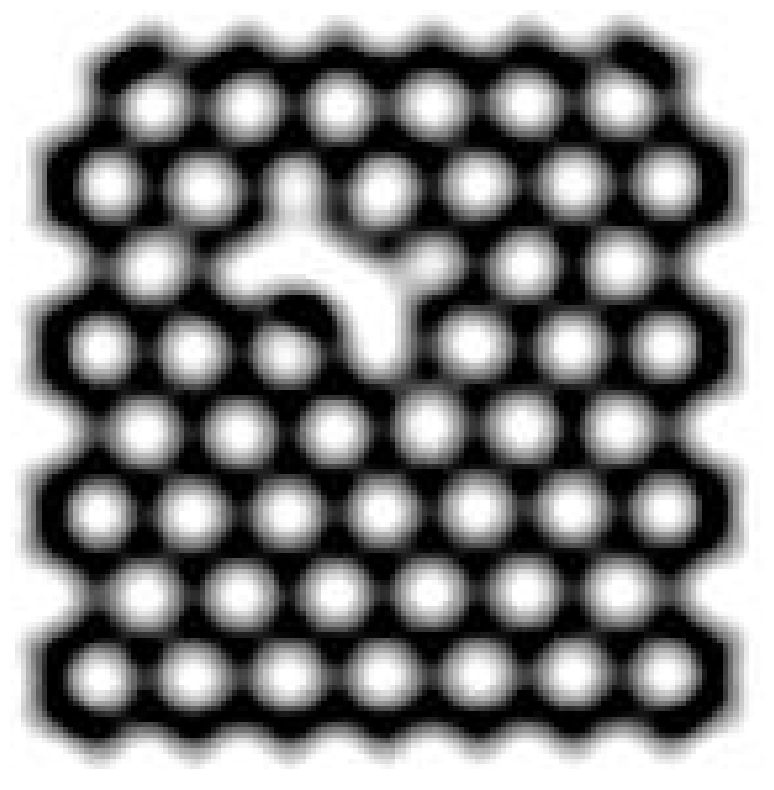

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path
import seaborn as sns

def visualize_predictions_clean(experimental_image_path, predictions, output_path):
    """
    Visualize the predictions on the experimental image without any text or color.
    """
    # Load the experimental image
    img = Image.open(experimental_image_path)
    
    # Convert to grayscale if needed
    if img.mode != 'L':
        img = img.convert('L')
    
    # Create a drawing context
    draw = ImageDraw.Draw(img)
    
    # Extract predicted values
    x, y, r = predictions['X'], predictions['Y'], predictions['R']
    
    # Draw circle (defect) in white
    bbox = (x - r, y - r, x + r, y + r)
    draw.ellipse(bbox, outline=255, width=3)
    
    # Draw center point in white
    draw.ellipse((x-3, y-3, x+3, y+3), fill=255)
    
    # Save the image with predictions (no text)
    img.save(output_path)
    print(f"Clean prediction visualization saved to: {output_path}")
    
    return img

def display_processed_experimental_image(experimental_image_path, output_path):
    """
    Display the processed experimental image in grayscale with axis on.
    """
    # Load the experimental image
    img = Image.open(experimental_image_path)
    
    # Convert to grayscale if needed
    if img.mode != 'L':
        img = img.convert('L')
    
    # Convert to numpy array
    img_array = np.array(img)
    
    # Display the image with axis on
    plt.figure(figsize=(10, 8))
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')  # Turn on axis
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    
    return img_array

def create_feature_importance_heatmap(importance_dfs, output_path):
    """
    Create a heatmap of feature importances across all targets.
    """
    # Combine all feature importance data into a single DataFrame
    combined_importance = pd.DataFrame()
    
    for target, df in importance_dfs.items():
        # Extract target name (remove 'importance_' prefix)
        target_name = target.replace('importance_', '')
        
        # Add feature importance for this target
        for _, row in df.iterrows():
            combined_importance.loc[row['feature'], target_name] = row['importance']
    
    # Fill NaN values with 0
    combined_importance = combined_importance.fillna(0)
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(combined_importance, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Feature Importance Across All Targets')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return combined_importance

def main():
    # Set paths
    experimental_image_path = r"\7_def.jpg"
    processed_experimental_path = r"\processed_experimental_image.jpg"
    output_dir = r"\experimental_results"
    
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Load predictions and feature importance data
    predictions_path = Path(output_dir) / "model_predictions.csv"
    predictions_df = pd.read_csv(predictions_path)
    predictions = predictions_df.iloc[0].to_dict()
    
    # Load feature importance data
    importance_dfs = {}
    for target in ['X', 'Y', 'R', 'target']:
        csv_path = Path(output_dir) / f"feature_importance_importance_{target}.csv"
        if csv_path.exists():
            importance_dfs[f'importance_{target}'] = pd.read_csv(csv_path)
    
    # Visualize predictions without text or color
    print("Creating clean visualization without text or color...")
    output_image_path = Path(output_dir) / "predicted_defects_clean.jpg"
    visualized_image = visualize_predictions_clean(
        processed_experimental_path, predictions, output_image_path
    )
    
    # Display the processed experimental image in grayscale with axis on
    print("Displaying processed experimental image with axis on...")
    processed_display_path = Path(output_dir) / "processed_experimental_display.jpg"
    display_processed_experimental_image(processed_experimental_path, processed_display_path)
    

if __name__ == "__main__":
    main()